# scPRINT use case on BPH

In this use-case, also presented in Figure 5 of our [manuscript](https://www.biorxiv.org/content/10.1101/2024.07.29.605556v1), we perform an extensive analysis of a multi studies dataset of benign prostatic hyperplasia. 

Our biological question is to check if there exist pre-cancerous cells that exhibits behaviors of mature cancer cells at this early stage of the disease. 

In those cells, we  want to know which genes might be implicated in cell state changes, and explore  potentially novel targets in the treatment of prostate cancer and BPH.

We will start with a fresh datasets coming from the [cellXgene database](https://cellxgene.cziscience.com/) and representing [2 studies of BPH](https://pathsocjournals.onlinelibrary.wiley.com/doi/10.1002/path.5751).

We will first explore these dataset to understand:

- what are the cell types that are present in the data
- what are the cell distributions (cell distributions? what are they?)
- what sequencers were used, etc.

We also want to confirm existing target in prostate cancer through precancerous lesion analysis, and find potentially novel ones that would serve as less invasive BPH treatments than current ones.

Finally we  want to know how these targets interacts and are involved in biological pathways.

We now showcase how to use scPRINT across its different functionalities to answer some of these questions.

## table of contents:

1. [Downloading and preprocessing](#downloading-and-preprocessing)
2. [Embedding and annotations](#embedding-and-annotations)
3. [Annotation cleanup](#annotation-cleanup)
4. [Clustering and differential expression](#clustering-and-differential-expression)
5. [Denoising and differential expression](#denoising-and-differential-expression)
6. [Gene network inference](#gene-network-inference)

Please note that although your adata needs to be processed in a similar way to what is shown in `1.` You can perform the analaysis in `2-3-4`, `5` or `6` in any order as they are completely distinct.


> In the notebook [cancer_usecase_part2.ipynb](./cancer_usecase_part2.ipynb) you will see how to analyse cell type specific gene regulatory networks.

These notebooks can be found and run from [docs/notebooks](https://github.com/cantinilab/scPRINT/tree/main/docs/notebooks).


### 🎴 YOU NEED TO FIRST HAVE A POPULATED LAMINDB INSTANCE (see README) 🎴

In [ ]:
# ! lamin load [MY_INSTANCE]

from huggingface_hub import hf_hub_download

from scprint import scPrint
from scdataloader import Preprocessor, utils
from scprint.tasks import GNInfer, Embedder, Denoiser, withknn

from scdataloader.utils import load_genes

from bengrn import BenGRN, get_sroy_gt, compute_genie3
from bengrn.base import train_classifier

from grnndata import utils as grnutils
from grnndata import read_h5ad

from anndata.utils import make_index_unique
from anndata import concat
import scanpy as sc

from matplotlib import pyplot as plt
import numpy as np
import lamindb as ln

%load_ext autoreload
%autoreload 2 

import torch

torch.set_float32_matmul_precision("medium")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Downloading and preprocessing

We now use [lamindb](https://lamin.ai/) to easily access cellxgene and download a dataset of normal and benign prostatic hyperplasia tissues.

data is available here https://cellxgene.cziscience.com/e/574e9f9e-f8b4-41ef-bf19-89a9964fd9c7.cxg/ .

We then use scDataloader's preprocessing method. This method is quite extensive and does a few things.. find our more about it [on its documentation](https://www.jkobject.com/scDataLoader/).

On our end we are using the preprocessor to make sure that the the gene expression that we have are raw counts and that we have enough information to use scPRINT (i.e., enough genes expressed and enough counts per cells across the dataset). 
 
Finally, the preprocessor will also increase the size of the expression matrix to be a fixed set of genes defined by the latest version of ensemble.

In [ ]:
cx_dataset = (
    ln.Collection.using(instance="laminlabs/cellxgene")
    .filter(name="cellxgene-census", version="2023-12-15")
    .one()
)

! the database (1.7.0) is ahead of your installed lamindb package (1.0.4)
→ please update lamindb: pip install "lamindb>=1.7,<1.8"
→ please update lamindb: pip install "lamindb>=1.7,<1.8"


! the database (1.7.0) is ahead of your installed lamindb package (1.0.4)
→ please update lamindb: pip install "lamindb>=1.7,<1.8"
! run input wasn't tracked, call `ln.track()` and re-run


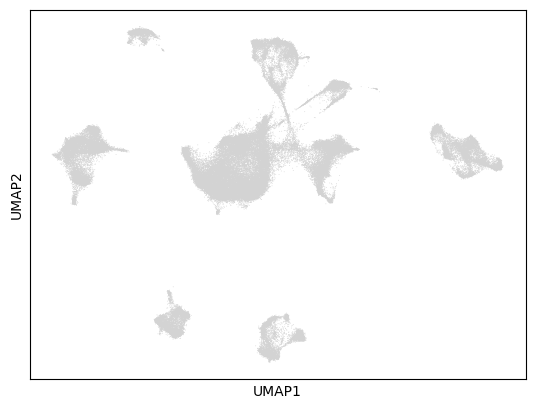

In [ ]:
prostate_adata = (
    cx_dataset.artifacts.filter(
        key="cell-census/2023-12-15/h5ads/574e9f9e-f8b4-41ef-bf19-89a9964fd9c7.h5ad"
    )
    .one()
    .load()
)
sc.pl.umap(prostate_adata)

In [45]:
# preprocessing using scDataloader
prostate_adata.obs.drop(columns="is_primary_data", inplace=True)
preprocessor = Preprocessor(do_postp=False)
prostate_adata = preprocessor(prostate_adata)

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 83451 renamining
filtered out 0 cells, 83451 renamining
Removed 0 genes.
validating


/pasteur/appa/homes/jkalfon/test/test/lib/python3.10/site-packages/scdataloader/preprocess.py:304: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata, organism=adata.obs.organism_ontology_term_id[0], need_all=False


startin QC
Seeing 13055 outliers (15.64% of total dataset):
done
AnnData object with n_obs × n_vars = 83451 × 70611
    obs: 'Sample', 'Lineage', 'Population', 'resolution_0.1', 'resolution_0.2', 'resolution_0.3', 'resolution_0.4', 'resolution_0.5', 'resolution_0.75', 'resolution_1', 'resolution_2', 'resolution_3', 'resolution_4', 'resolution_5', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Stress1', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_m

# loading the model:

We now start to load a large version of scPRINT from a specific checkpoint. Please [download](https://huggingface.co/jkobject/scPRINT/tree/main) the checkpoints following the instructions in the README. 

Note that for any other notebooks presented in this repo, there might not be such a care on how we load the model. Refer to this part bellow to have a good understanding of the different parametrization of loading pretrained model weights.



In [ ]:
model_checkpoint_file = hf_hub_download(
    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
)
# model_checkpoint_file = "../data/temp/o2uniqsx/epoch=18-step=133000.ckpt"
# "/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/last.ckpt"
#'../data/temp/o2uniqsx/epoch=18-step=133000.ckpt',
# "../../xzp23r4p.ckpt"
model_checkpoint_file


'/pasteur/appa/homes/jkalfon/.cache/huggingface/hub/models--jkobject--scPRINT/snapshots/d79fad0ff77e19d9ba0c2fad9dfc993b37e92d6d/v2-medium.ckpt'

In [ ]:
# make sure that you check if you have a GPU with flashattention or not (see README)
try:
    m = torch.load(model_checkpoint_file)
# if not use this instead since the model weights are by default mapped to GPU types
except RuntimeError:
    m = torch.load(model_checkpoint_file, map_location=torch.device("cpu"))

# again here by default the model was trained with flash attention, so if you do not have a GPU you will need to replace the attention mechanism with regular attention
transformer = "flash" if torch.cuda.is_available() else "normal"

# both are for compatibility issues with different versions of the pretrained model, so we need to load it with the correct transformer
if "prenorm" in m["hyper_parameters"]:
    m["hyper_parameters"].pop("prenorm")
    torch.save(m, model_checkpoint_file)
if "label_counts" in m["hyper_parameters"]:
    # you need to set precpt_gene_emb=None otherwise the model will look for its precomputed gene embeddings files although they were already converted into model weights, so you don't need this file for a pretrained model
    model = scPrint.load_from_checkpoint(
        model_checkpoint_file,
        precpt_gene_emb=None,
        classes=m["hyper_parameters"]["label_counts"],
        transformer=transformer,
    )
else:
    model = scPrint.load_from_checkpoint(
        model_checkpoint_file, precpt_gene_emb=None, transformer=transformer
    )

# this might happen if you have a model that was trained with a different set of genes than the one you are using in the ontology (e.g. newer ontologies), While having genes in the onlogy not in the model is fine. the opposite is not, so we need to remove the genes that are in the model but not in the ontology
missing = set(model.genes) - set(load_genes(model.organisms).index)
if len(missing) > 0:
    print(
        "Warning: some genes missmatch exist between model and ontology: solving...",
    )
    model._rm_genes(missing)

# again if not on GPU you need to convert the model to float64
if not torch.cuda.is_available():
    model = model.to(torch.float32)

# you can perform your inference on float16 if you have a GPU, otherwise use float64
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# the models are often loaded with some parts still displayed as "cuda" and some as "cpu", so we need to make sure that the model is fully on the right device
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

RuntimeError caught: scPrint is not attached to a `Trainer`.


## Embedding and annotations

We will then use out Embedder class to embed the data and annotate the cells. These classes are how we parametrize and access the different functions of `scPRINT`. Find out more about its parameters in our [documentation](https://www.jkobject.com/scPrint/).

In [ ]:
embedder = Embedder(
    # can work on random genes or most variables etc..
    how="random expr",
    # number of genes to use
    max_len=4000,
    # the model is trained on a minibatch of 64 cells but you can choose whatever
    batch_size=32,
    # for the dataloading
    num_workers=8,
    # we will only use the cell type embedding here.
    pred_embedding=["cell_type_ontology_term_id"],
    # , "disease_ontology_term_id"],
    # we will now
    save_every=40_000,
    dtype=dtype,
)

In [ ]:
# create the embedding
prostate_adata, metrics = embedder(model, prostate_adata, cache=False)

In [8]:
prostate_adata

AnnData object with n_obs × n_vars = 83451 × 70704
    obs: 'Sample', 'Lineage', 'Population', 'resolution_0.1', 'resolution_0.2', 'resolution_0.3', 'resolution_0.4', 'resolution_0.5', 'resolution_0.75', 'resolution_1', 'resolution_2', 'resolution_3', 'resolution_4', 'resolution_5', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Stress1', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_r

## Annotation cleanup

scPRINT generates predictions over hundreds of possible labels for each cell. 

It is often advised to "cleanup" the predictions, e.g. making sure to remove low frequency cells and misslabellings. 

Here, we use the most straightforward approach which is to remove any annotations that appear a small number of times.

A better approach would be doing majority voting over cell clusters as it would aggregate and smoothout the predictions over multiple cells. it would also remove most of the low frequency mistakes in the predictions.

We will also have a look at the embeddings of `scPRINT` by plotting its UMAP visualization.


<Axes: ylabel='count'>

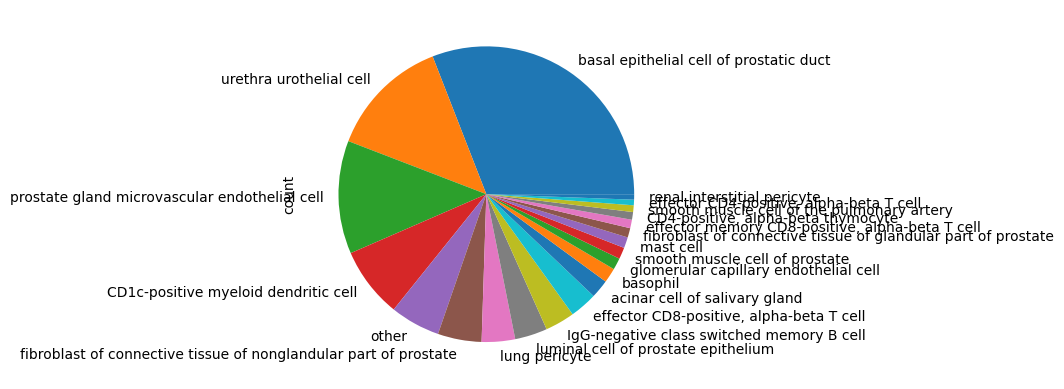

In [ ]:
# cleaning up the cell types
prostate_adata.obs["cleaned_pred_cell_type_ontology_term_id"] = prostate_adata.obs[
    "conv_pred_cell_type_ontology_term_id"
].astype(str)
prostate_adata.obs.loc[
    ~prostate_adata.obs["conv_pred_cell_type_ontology_term_id"].isin(
        [
            k
            for k, v in prostate_adata.obs["conv_pred_cell_type_ontology_term_id"]
            .value_counts()
            .items()
            if v > 400
        ]
    ),
    "cleaned_pred_cell_type_ontology_term_id",
] = "other"
prostate_adata.obs["cleaned_pred_cell_type_ontology_term_id"].value_counts().plot.pie()

<Axes: ylabel='count'>

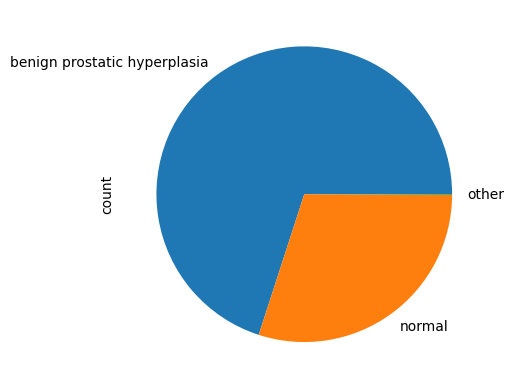

In [ ]:
# cleaning up the diseases
prostate_adata.obs["cleaned_pred_disease_ontology_term_id"] = prostate_adata.obs[
    "conv_pred_disease_ontology_term_id"
].astype(str)
prostate_adata.obs.loc[
    ~prostate_adata.obs["conv_pred_disease_ontology_term_id"].isin(
        [
            k
            for k, v in prostate_adata.obs["conv_pred_disease_ontology_term_id"]
            .value_counts()
            .items()
            if v > 1000
        ]
    ),
    "cleaned_pred_disease_ontology_term_id",
] = "other"
prostate_adata.obs["cleaned_pred_disease_ontology_term_id"].value_counts().plot.pie()

In [13]:
prostate_adata

AnnData object with n_obs × n_vars = 83451 × 70704
    obs: 'Sample', 'Lineage', 'Population', 'resolution_0.1', 'resolution_0.2', 'resolution_0.3', 'resolution_0.4', 'resolution_0.5', 'resolution_0.75', 'resolution_1', 'resolution_2', 'resolution_3', 'resolution_4', 'resolution_5', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Stress1', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_r

In [14]:
# do louvain mutliple times
sc.pp.neighbors(prostate_adata, n_neighbors=10, use_rep="scprint_emb")
# using multiple resolutions can help spotting smaller clusters
sc.tl.louvain(prostate_adata, resolution=0.5, key_added="louvain_0.5")
sc.tl.louvain(prostate_adata, resolution=1.0, key_added="louvain_1.0")
# do umap
sc.tl.umap(prostate_adata, n_components=2, random_state=42)
# plot

In [16]:
prostate_adata

AnnData object with n_obs × n_vars = 83451 × 70704
    obs: 'Sample', 'Lineage', 'Population', 'resolution_0.1', 'resolution_0.2', 'resolution_0.3', 'resolution_0.4', 'resolution_0.5', 'resolution_0.75', 'resolution_1', 'resolution_2', 'resolution_3', 'resolution_4', 'resolution_5', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Stress1', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_r

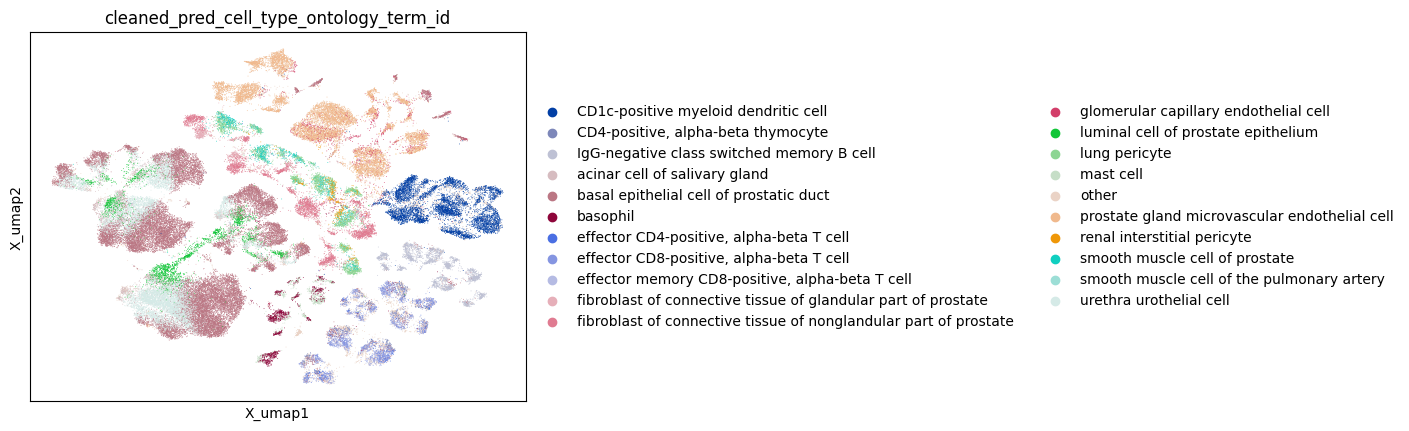

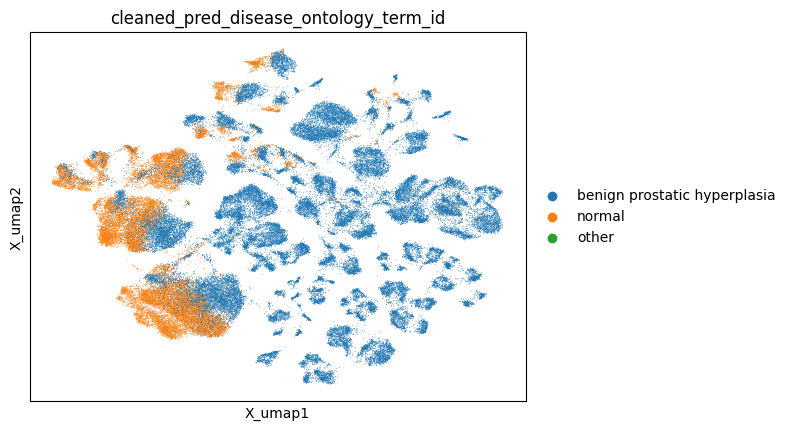

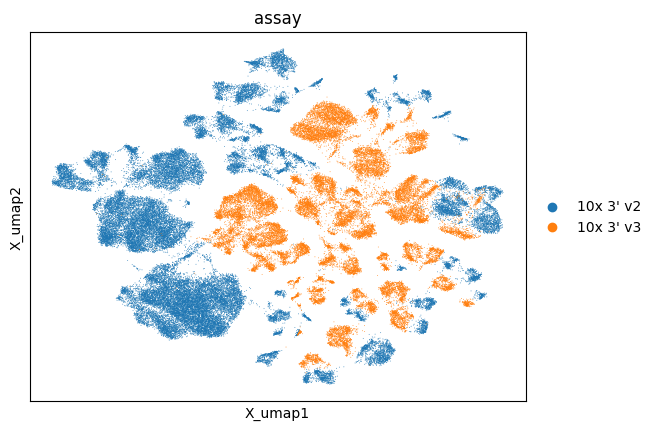

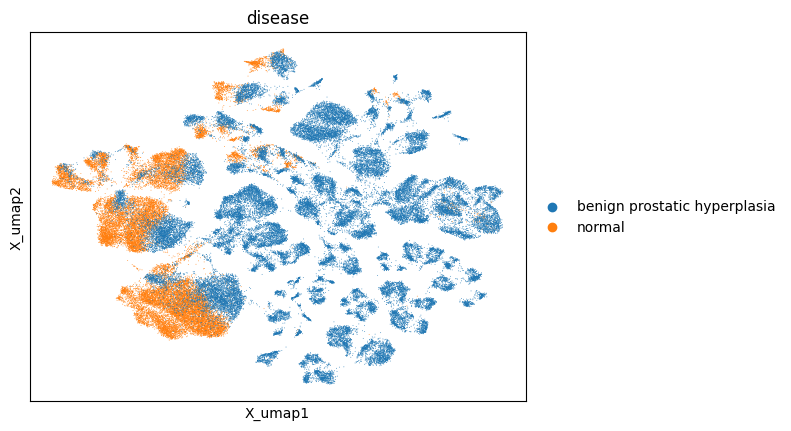

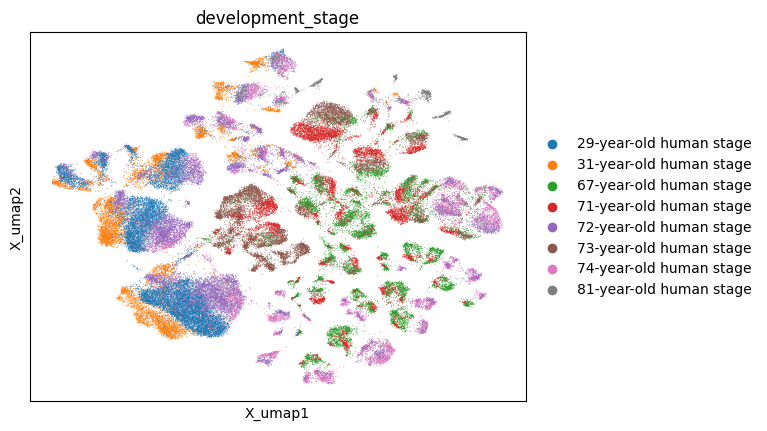

In [ ]:
sc.pl.embedding(
    prostate_adata, basis="X_umap", color=["cleaned_pred_cell_type_ontology_term_id"]
)
sc.pl.embedding(
    prostate_adata, basis="X_umap", color=["cleaned_pred_disease_ontology_term_id"]
)
sc.pl.embedding(prostate_adata, basis="X_umap", color=["assay"])
sc.pl.embedding(prostate_adata, basis="X_umap", color=["disease"])
sc.pl.embedding(prostate_adata, basis="X_umap", color=["development_stage"])

In [19]:
prostate_adata.obs.cleaned_pred_cell_type_ontology_term_id.value_counts().head(20)

cleaned_pred_cell_type_ontology_term_id
basal epithelial cell of prostatic duct                             25801
urethra urothelial cell                                             11050
prostate gland microvascular endothelial cell                       10321
CD1c-positive myeloid dendritic cell                                 6427
other                                                                4567
fibroblast of connective tissue of nonglandular part of prostate     3995
lung pericyte                                                        3045
luminal cell of prostate epithelium                                  2960
IgG-negative class switched memory B cell                            2701
effector CD8-positive, alpha-beta T cell                             2499
acinar cell of salivary gland                                        1689
basophil                                                             1340
glomerular capillary endothelial cell                                106

In [20]:
# we save for next time
prostate_adata.write_h5ad("../../data/temp/prostate_combined_latest.h5ad")

In [6]:
prostate_adata = sc.read_h5ad("../../data/temp/prostate_combined_latest.h5ad")

## Clustering and differential expression

We will now cluster using the louvain algorithm on a kNN graph. 

Once we detect a cluster of interest we will perform differential expression analysis on it. Taking as example some B-cell clusters, we will use scanpy's implementation of rank_gene_groups for our differential expression

<Axes: title={'center': 'louvain_0.5'}, xlabel='X_umap1', ylabel='X_umap2'>

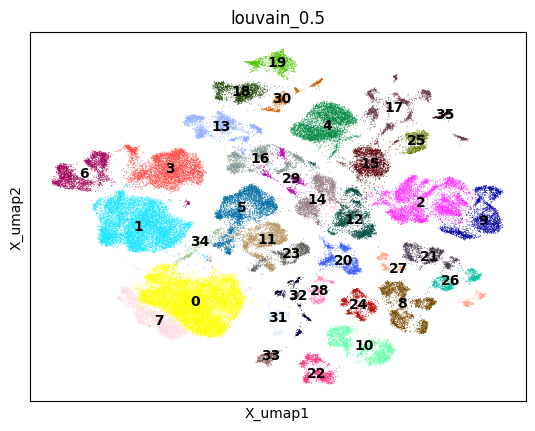

In [ ]:
# check clusters
sc.pl.embedding(
    prostate_adata,
    basis="X_umap",
    color="louvain_0.5",
    show=False,
    legend_loc="on data",
)

In [ ]:
# check cluster 9
i = 3
loc = prostate_adata.obs["louvain_0.5"] == str(i)
(
    prostate_adata.obs[loc].conv_pred_disease_ontology_term_id.value_counts().head(2),
    prostate_adata.obs[loc].conv_pred_cell_type_ontology_term_id.value_counts().head(),
)

(conv_pred_disease_ontology_term_id
 normal                          3359
 benign prostatic hyperplasia    1441
 Name: count, dtype: int64,
 conv_pred_cell_type_ontology_term_id
 basal epithelial cell of prostatic duct    2785
 urethra urothelial cell                    1487
 luminal cell of prostate epithelium         260
 acinar cell of salivary gland               198
 nasal mucosa goblet cell                     26
 Name: count, dtype: int64)

In [ ]:
# check cluster 11
i = 26
loc = prostate_adata.obs["louvain_0.5"] == str(i)
(
    prostate_adata.obs[loc]
    .cleaned_pred_disease_ontology_term_id.value_counts()
    .head(2),
    prostate_adata.obs[loc]
    .cleaned_pred_cell_type_ontology_term_id.value_counts()
    .head(5),
)

(cleaned_pred_disease_ontology_term_id
 benign prostatic hyperplasia    856
 other                             1
 Name: count, dtype: int64,
 cleaned_pred_cell_type_ontology_term_id
 IgG-negative class switched memory B cell    777
 basal epithelial cell of prostatic duct       49
 other                                         25
 effector CD8-positive, alpha-beta T cell       3
 glomerular capillary endothelial cell          2
 Name: count, dtype: int64)

In [ ]:
prostate_adata.obs[
    prostate_adata.obs.cleaned_pred_cell_type_ontology_term_id
    == "IgG-negative class switched memory B cell"
]["louvain_0.5"].value_counts()

louvain_0.5
21    1202
26     777
27     708
8        5
10       4
2        2
9        1
15       1
12       1
3        0
0        0
1        0
11       0
5        0
13       0
14       0
16       0
6        0
7        0
4        0
19       0
18       0
17       0
20       0
23       0
22       0
25       0
24       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
Name: count, dtype: int64

In [ ]:
# We have find a nice IgG-negative class switched memory B cell cluster. let's use it and define a clean annotation for a plot
loc = loc & (
    prostate_adata.obs.cleaned_pred_cell_type_ontology_term_id
    == "IgG-negative class switched memory B cell"
)
prostate_adata.obs[loc].cleaned_pred_disease_ontology_term_id.value_counts().head(2)

cleaned_pred_disease_ontology_term_id
benign prostatic hyperplasia    776
other                             1
Name: count, dtype: int64

In [ ]:
# making a "focus" annotation for the B-cell to generate a nice plot of the B-cell cluster only
prostate_adata.obs["focus"] = "other"
prostate_adata.obs.loc[loc, "focus"] = "memory B cell"
prostate_adata.obs.loc[
    loc
    & (
        prostate_adata.obs["cleaned_pred_disease_ontology_term_id"]
        == "benign prostatic hyperplasia"
    ),
    "focus",
] = "BPH associated memory B cell"
prostate_adata.obs["focus"].value_counts()

focus
other                           82674
BPH associated memory B cell      776
memory B cell                       1
Name: count, dtype: int64

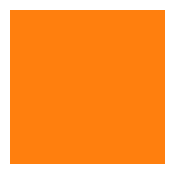

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns

color = sns.color_palette()[1]
fig, ax = plt.subplots(figsize=(2, 2))
rect = patches.Rectangle((0, 0), 1, 1, facecolor=color)
ax.add_patch(rect)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")
plt.show()

... storing 'focus' as categorical
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Axes: title={'center': 'focus'}, xlabel='scprint_umap_rot1', ylabel='scprint_umap_rot2'>

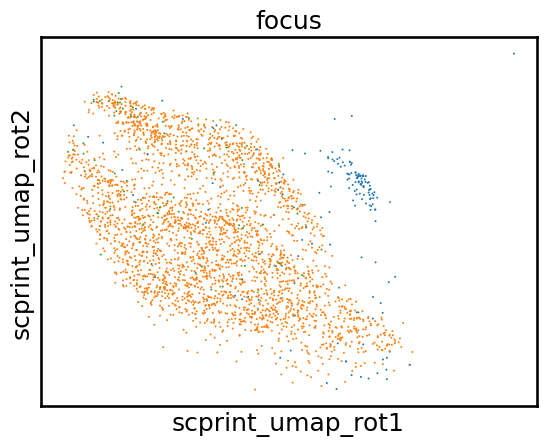

In [ ]:
# looking at the B-cell cluster. We can see some normal and BPH-associated memory B-cells
sc.pl.embedding(
    prostate_adata[
        (prostate_adata.obs["louvain_1.0"] == str(i))
        & (prostate_adata.obsm["scprint_umap"][:, 0] > 4)
    ],
    basis="scprint_umap",
    color="focus",
    show=False,
    size=8,
    title="Switched memory B-cell cluster",
    legend_loc="right margin",
)

... storing 'focus' as categorical


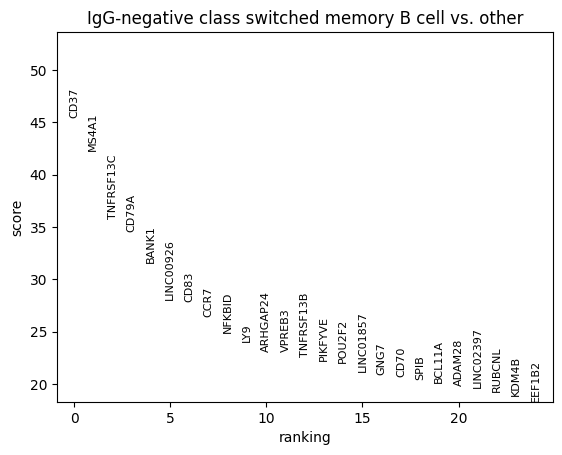

In [ ]:
# now the diff expression between B-cells and the rest
sc.tl.rank_genes_groups(
    prostate_adata,
    groupby="cleaned_pred_cell_type_ontology_term_id",
    groups=["IgG-negative class switched memory B cell"],
    reference="other",
    method="t-test",
)
# Plot the most differentially expressed genes
sc.pl.rank_genes_groups(prostate_adata, n_genes=25, sharey=False, gene_symbols="symbol")
# super strong B cell markers

## Denoising and differential expression

What we found out from our previous analysis is that there is not a lot of normal (i.e. healthy) B-cells in our cluster, most of them are BPH associated. In this case, if we wanted to compare BPH B-cells to normal B-cells we might be very underpowered...

Instead of going to look for some other dataset, let's use `scPRINT` to increase the depth of the expression profile of the cells, virtually adding more signal to our dataset.

We will use the `Denoiser` class (see more about the class in our [documentation](https://www.jkobject.com/scPrint/)) in a similar way `Trainer` is used in pytorch lightning to denoise the expression profile of the cells.

We will then show the results of differential expression analysis before and after denoising.

In [ ]:
# here we compare memory B-cell in BPH to normal memory B cells before denoising
sc.tl.rank_genes_groups(
    prostate_adata,
    groupby="focus",
    groups=["BPH associated memory B cell"],
    reference="memory B cell",
    method="t-test",
)
# Plot the most differentially expressed genes
sc.pl.rank_genes_groups(prostate_adata, n_genes=25, sharey=False, gene_symbols="symbol")
# super strong B cell markers

KeyError: 'focus'

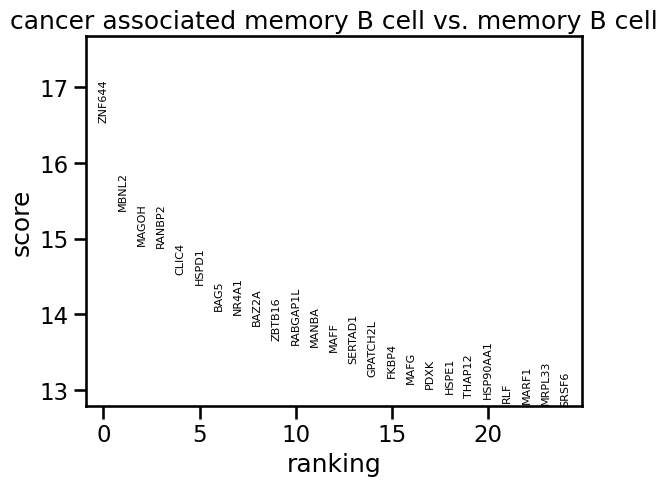

In [ ]:
# here we compare memory B-cell in BPH to normal memory B cells before denoising
sc.tl.rank_genes_groups(
    prostate_adata,
    groupby="focus",
    groups=["BPH associated memory B cell"],
    reference="memory B cell",
    method="t-test",
)
# Plot the most differentially expressed genes
sc.pl.rank_genes_groups(prostate_adata, n_genes=25, sharey=False, gene_symbols="symbol")
# super strong B cell markers

In [ ]:
# perform denoising
denoise = Denoiser(
    # could be on top differentially expressed genes or on random expressed genes in the cell (completed by random non expressed gene)
    how="random expr",
    # the size of the minibatch (need to fit in memory)
    batch_size=20,
    num_workers=8,
    # the number of genes to use
    max_len=5000,
    # the number of cells to use (here more than what we will use so we will use everything)
    max_cells=10_000,
    doplot=False,
    # how much do we want to increase the depth / counts of the cells (here, 10x)
    predict_depth_mult=7,
    dtype=dtype,
)
metrics, idx, denoised_adata = denoise(
    model, prostate_adata[prostate_adata.obs["focus"] != "other"]
)

100%|██████████| 2/2 [00:58<00:00, 29.10s/it]


AnnData object with n_obs × n_vars = 32 × 44741
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


In [ ]:
# The error occurs because we need to ensure the masks have compatible shapes
# For AnnData objects, we need to use the obs_names and var_names for proper indexing
row_mask = prostate_adata.obs_names[prostate_adata.obs["focus"] != "other"]
col_mask = prostate_adata.var_names[
    prostate_adata.var.index.isin(denoised_adata.var.index)
]
prostate_adata[row_mask, col_mask].X = denoised_adata.X[
    :, denoised_adata.var.index.isin(prostate_adata.var.index)
]

KeyboardInterrupt: 

In [83]:
denoised_adata

AnnData object with n_obs × n_vars = 777 × 44756
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_pi', 'scprint_theta'

In [ ]:
# now what we are doing here it to complete the expression profile with the denoised values. this is not done by default for now
prostate_adata.X[
    prostate_adata.obs["focus"] != "other",
    prostate_adata.var.index.isin(denoised_adata.var.index),
] = denoised_adata.X[:, denoised_adata.var.index.isin(prostate_adata.var.index)]

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (777,) and arg 1 with shape (23142,).

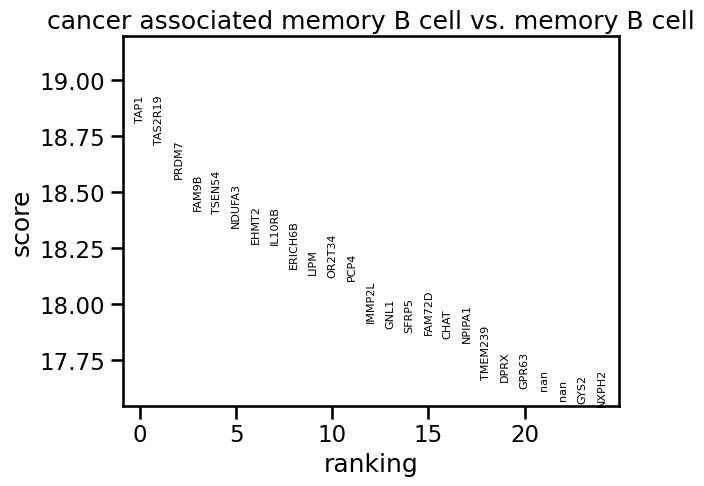

In [ ]:
# now we compare memory B-cell in BPH to normal memory B cells after denoising
sc.tl.rank_genes_groups(
    prostate_adata,
    groupby="focus",
    groups=["BPH associated memory B cell"],
    reference="memory B cell",
    method="t-test",
)
# Plot the most differentially expressed genes
sc.pl.rank_genes_groups(prostate_adata, n_genes=25, sharey=False, gene_symbols="symbol")
# super strong B cell markers

In [9]:
prostate_adata.write_h5ad("../../data/temp/prostate_combined_denoised.h5ad")

In [10]:
prostate_adata = sc.read_h5ad("../../data/temp/prostate_combined_denoised.h5ad")
prostate_adata

AnnData object with n_obs × n_vars = 83451 × 70116
    obs: 'Sample', 'Lineage', 'Population', 'resolution_0.1', 'resolution_0.2', 'resolution_0.3', 'resolution_0.4', 'resolution_0.5', 'resolution_0.75', 'resolution_1', 'resolution_2', 'resolution_3', 'resolution_4', 'resolution_5', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Stress1', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'tota

## Gene network inference

Finally we will use scPRINT to infer gene networks on another cell of interest, the fibroblasts, in both normal and BPH conditions.

We will  use the `GRNfer` class to infer gene networks. (_see the [cancer_usecase_part2.ipynb](./cancer_usecase_part2.ipynb) for more details on how to analyse the gene networks._)

In [38]:
prostate_adata.obs.cleaned_pred_cell_type_ontology_term_id.value_counts().head(20)

cleaned_pred_cell_type_ontology_term_id
basal epithelial cell of prostatic duct                             25740
prostate gland microvascular endothelial cell                       12165
urethra urothelial cell                                             10952
CD1c-positive myeloid dendritic cell                                 6898
other                                                                5869
aortic smooth muscle cell                                            3970
effector CD8-positive, alpha-beta T cell                             3925
pancreatic acinar cell                                               3711
luminal cell of prostate epithelium                                  3435
fibroblast of connective tissue of nonglandular part of prostate     3334
mucous neck cell                                                     3260
IgG-negative class switched memory B cell                            2932
basophil                                                             186

In [ ]:
loc = (
    prostate_adata.obs.cleaned_pred_cell_type_ontology_term_id
    == "fibroblast of connective tissue of glandular part of prostate"
)
prostate_adata.obs[loc]["cleaned_pred_disease_ontology_term_id"].value_counts()

cleaned_pred_disease_ontology_term_id
benign prostatic hyperplasia    1482
normal                           673
other                              4
Name: count, dtype: int64

In [ ]:
prostate_adata.obs[loc]["louvain_1.0"].value_counts().head(10)

louvain_1.0
5     1458
4      671
17      10
8        8
7        7
0        3
9        2
6        0
3        0
1        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
2        0
18       0
Name: count, dtype: int64

In [ ]:
loc = loc & (prostate_adata.obs["louvain_1.0"] == str(5))
prostate_adata.obs[loc]["cleaned_pred_disease_ontology_term_id"].value_counts()

cleaned_pred_disease_ontology_term_id
benign prostatic hyperplasia    790
normal                          664
other                             4
Name: count, dtype: int64

In [ ]:
prostate_adata.obs["fibro"] = None
prostate_adata.obs.loc[loc, "fibro"] = "fibroblasts"
prostate_adata.obs.loc[
    loc
    & (
        prostate_adata.obs.cleaned_pred_disease_ontology_term_id
        == "benign prostatic hyperplasia"
    ),
    "fibro",
] = "BPH associated fibroblasts"

... storing 'focus' as categorical
... storing 'fibro' as categorical
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


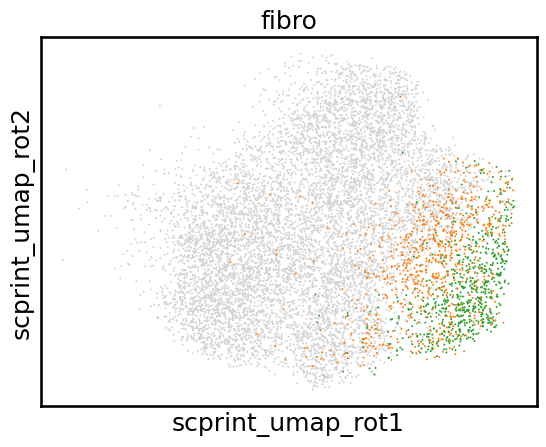

In [ ]:
sc.pl.embedding(
    prostate_adata[
        prostate_adata.obs["louvain_1.0"].isin(["5", "4"])
        & (prostate_adata.obsm["scprint_umap"][:, 1] > 10)
    ],
    basis="scprint_umap_rot",
    color="fibro",
    show=False,
    size=8,
    title="Fibroblasts cluster",
    legend_loc="right margin",
)

In [ ]:
grn_inferer = GNInfer(
    # here we use the most variable genes across the fibroblasts vs the rest to find the num_genes genes we want to use to compute our gene network
    how="most var across",
    # how="random expr",
    # we will preprocess the attention matrix with softmax
    # this means that instead of being directly the QK^T matrix of the attention operation we apply softmax to the rows (see https://medium.com/@mayanksultania/transformers-101-tokens-attention-and-beyond-b080a900ca6c)
    preprocess="softmax",
    # we don't aggregate the different gene networks coming from the different heads over the different layers here, we will do it manually afterward
    head_agg="none",
    # we will not use any filtration here, but you can use "none" or "topk" for top k connections per genes or "thresh" for a defined threshold, and more
    filtration="none",
    # here if we generate the attention matrices by performing a task, like denoising or by just passing the expression profile through the model
    forward_mode="none",
    # the number of genes to use (here the 4000 most variable genes)
    num_genes=4000,
    # the max number of cell to use per cell type
    max_cells=300,
    doplot=False,
    batch_size=16,
    # the column in anndata the defines the cell type
    cell_type_col="fibro",
    dtype=dtype,
    # list of transformer layers to extract the Gene Network from
    layer=list(range(model.nlayers))[:],
)

In [ ]:
# I was missing this from the model (not really necessary)
prostate_adata.obs["fibro"] = prostate_adata.obs["fibro"].astype(str)
prostate_adata.obs[
    prostate_adata.obs["fibro"] == "BPH associated fibroblasts"
].disease.value_counts()

AttributeError: 'DataFrame' object has no attribute 'fibro'

## output 

the output of the function is a new Anndata in the form of a GRnnData object see [cantinilab/grnndata](https://github.com/cantinilab/GRnnData)

the .varp['GRN'] attribute which contains the full Gene Network in this case (a fully connected directed weighted graph between all 4000 genes selected)

because we selected head_agg to "none" that means it actually is not of size 4000x4000 but 4000x4000x(n_layers*n_heads). by taking the mean over this last dimension with mean-aggregate the different gene networks coming from the different heads over the different layers into a single 4000x4000 matrix.

In [ ]:
# compute GRNs on fibroblasts, we use all the atetetion layers
grn = grn_inferer(model, prostate_adata, cell_type="fibroblasts"))

# highlight differential links on genes that are expressed in both
grn.varp["all"] = grn.varp["GRN"].copy()
# now we aggregate the heads by taking their average
grn.varp["GRN"] = grn.varp["GRN"].mean(-1)
grn.write_h5ad("../../data/temp/prostate_fibro_grn_all.h5ad")


In [ ]:
# same on the BPH associated fibroblasts
# I wanted to use only the ones that the labellers had defined as coing from BPH
prostate_adata.obs.loc[
    (prostate_adata.obs.fibro == "BPH associated fibroblasts")
    & (prostate_adata.obs.disease == "benign prostatic hyperplasia"),
    "fibro",
] = "true BPH associated fibroblasts"

grn_c = grn_inferer(
    model, prostate_adata, cell_type="true cancer associated fibroblasts"
)
# highlight differential links on genes that are expressed in both
grn_c.varp["all"] = grn_c.varp["GRN"].copy()
grn_c.varp["GRN"] = grn_c.varp["GRN"].mean(-1)
grn_c.write_h5ad("../../data/temp/prostate_BPH_fibro_grn_all.h5ad")